# Nagel & Schreckenberg traffic simulation

The code below implements the rules of the Nagel & Schreckenberg model and keeps track of the average traffic flow at each time step.

**Tasks:**

* **Review the code** to see how the rules are implemented. You do **not** necessarily have to understand the optimized code. The unoptimized code was left in because it is more readable and you should make sure you understand that. The optimized code shows how to use NumPy techniques to speed up the simulation considerably, but also make it less readable.
* **Think about the examples show below** to check your conceptual understanding of the rules.

In [1]:
import numpy as np

In [2]:
class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

## Sanity check

Compare the optimized and unoptimized update methods to see if they match.

In [3]:
print('Unoptimized:')
np.random.seed(123)  # Set the seed so we can compare to random simulations
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
initial_state = sim.state.copy()
for i in range(10):
    sim.display()
    sim.update(optimized=False)
final_state = sim.state.copy()

print()
print('Optimized')
np.random.seed(123)  # Set the seed so we can compare to random simulations
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
sim.state = initial_state.copy()
for i in range(10):
    sim.display()
    sim.update(optimized=True)

print()
print('Final states match?', np.all(final_state == sim.state))

Unoptimized:
5....1..3.5442....3..2.......54.........43....30..
...3...2.1000...3..1....3....0.....5....0....400..
.....2.0.000.1....2..2......4.1........4.1...00.1.
2....0..1000..1.....2..2.....1..2.......1.1..0.1..
..2..0..000.1..1......2...3...1....3.....1.1.0..1.
2..1..1.00.1.1...2.......3...3.1......3..0.0..1...
.1..1.0.0.1.1..2....3......2.0..1......1..10....2.
...2.10..1.1.1...2......4...1.1..1.......20.1....1
.2..100...1.1..2...2......2.0..1...2.....00..1....
...2000....1..2..2....3....10....2...2...00....2..

Optimized
5....1..3.5442....3..2.......54.........43....30..
...3...2.1000...3..1....3....0.....5....0....400..
.....2.0.000.1....2..2......4.1........4.1...00.1.
2....0..1000..1.....2..2.....1..2.......1.1..0.1..
..2..0..000.1..1......2...3...1....3.....1.1.0..1.
2..1..1.00.1.1...2.......3...3.1......3..0.0..1...
.1..1.0.0.1.1..2....3......2.0..1......1..10....2.
...2.10..1.1.1...2......4...1.1..1.......20.1....1
.2..100...1.1..2...2......2.0..1...2.....00..1....
...2000

## Example: Simple acceleration

A single car accelerates without random slow down and moves around the circular road.

 * Each line shows a dot for an empty cell and a number for a car.
 * The number is the speed of the car just after it moved (and before it attempts to accelerate).
 * So a car with speed $s$ at step $t+1$ always moved $s$ spaces from its position at step $t$.

In [4]:
sim = TrafficSimulation(
    road_length=20, car_density=1/20, max_speed=5, prob_slow=0)
sim.state[sim.state > 0] = 0  # Force the speed of the car to be 0
for i in range(10):
    sim.display()
    sim.update()

0...................
.1..................
...2................
......3.............
..........4.........
...............5....
5...................
.....5..............
..........5.........
...............5....


## Example: Braking

One car has to slow down for another car. There is still no random slow down. The car on the left has to brake from line 2 to line 3. Thereafter, it never has to brake again.

In [5]:
sim = TrafficSimulation(
    road_length=20, car_density=2/20, max_speed=5, prob_slow=0)
sim.state[:7] = [-1, -1, 2, -1, -1, -1, 1]
for i in range(10):
    sim.display()
    sim.update()

..2...1..4.......0..
.....3..2.....5...1.
2......2...3.....3..
...3......3....4...2
..3....4......4...3.
.3....4.....5....3..
3....4.....5....4...
....4.....5....4...3
...4.....5....4...3.
..4.....5....4...3..


## Example: Random slow down

Here, we set the random slow down probability to 0.5 (which is fairly high). We see both cars accelerate to 5 but from time to time, a car's speed reduces from 5 to 4, or the car will not accelerate – that is, it accelerates by 1 and then slows down by 1 again.

In [6]:
np.random.seed(123)
sim = TrafficSimulation(
    road_length=50, car_density=2/50, max_speed=5, prob_slow=0.5)
for i in range(10):
    sim.display()
    sim.update()

..........5..2....................................
...........1...2..................................
.............2....3...............................
................3.....4...........................
...................3......4.......................
......................3........5..................
.........................3.........4..............
.............................4..........5.........
..................................5.........4.....
.......................................5.........5


## Example: Free-flowing traffic

If the car density is low enough, cars rarely (or never) have to slow down for other cars. They might still slow down randomly though.

In [7]:
sim = TrafficSimulation(
    road_length=50, car_density=0.1, max_speed=5, prob_slow=0.1)
for i in range(20):
    sim.display()
    sim.update()

..4.5..1..................4......................4
.2.1..2..2....................4...................
.0..1...2...3......................5..............
..1...2...2.....4.......................5.........
....2....3...3.......5.......................5....
5......3....3....4........5.......................
....4......4....4.....5........5..................
.........5.....4.....5.....5........5.............
..............5.....5.....5.....5........5........
...................5.....5.....5.....5........5...
.5......................5.....5....4.....4........
......5......................5...3......5.....5...
.5........4....................2.....4.......5....
5.....5........5..................3.......5.......
.....5.....5........5.................4........5..
..5.......5.....5.......4..................5......
.......5.......5.....5.......5.................4..
..5.........5.......5.....5.......5...............
.......5.........5......4......5.......5..........
...........4..........5......5.

## Example: Traffic jams 1

With more cars on the road and with some random slow down, our first minor traffic jams appear – note the 0s.

In [8]:
np.random.seed(123)
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0.2)
for i in range(20):
    sim.display()
    sim.update()

5.........5.42....3...........4.........4.....3...
.....5.....10..2......4............5.........5...3
...4......50.1....3........5...........4........3.
..4.....5.0.1..2......4.........5...........5.....
.......5.1.1..2...3.......4..........5...........5
....5..0..1.1....3....4........5.........4........
......20..0...2......4.....5........5.........5...
.5....0.1..1.....3.......4......5........5........
.....4.1..2..2.......4.......4.......5........5...
.5....1..2..2..2.........4........5.......5.......
.....4..2..2..2...3..........4.........5.......5..
..5....2..2..2..2.....4...........5.........5.....
......4..2..2..2...3.......5...........5.........5
....5..1...2..2...3...3.........5...........5.....
......2.1....2...3...3....4..........5...........5
....5.0...2.....3..2.....4.....5..........5.......
....0..1.....3....2...3.......5.....5..........5..
..5.0....2.......4...3....4........5.....5........
..0..1......3.......3...3.....4........4......5...
4..1...2.......3.......3....4..

## Example: Traffic jams 2

Without random slow down, there are no traffic jams at this car density since cars can space themselves out on the road and will never overbrake.

In [9]:
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0)
for i in range(20):
    sim.display()
    sim.update()

....5...2..2......0.......4.3.....1.3.............
.......3..2...3....1.......1....4..1....4.........
.........2...3....4..2.......2....2..2.......5....
5...........3....4..2...3.......3...2...3.........
.....5..........4..2...3....4......3...3....4.....
..........5.......2...3....4.....5....3....4.....5
....5..........5.....3....4.....5....4....4.....5.
...5.....5..........5....4.....5....4....4.....5..
..5.....5.....5.........4.....5....4....4.....5...
.5.....5.....5.....5.........5....4....4.....5....
5.....5.....5.....5.....5........4....4.....5.....
.....5.....5.....5.....5.....5.......4.....5.....5
....5.....5.....5.....5.....5.....5.......5.....5.
...5.....5.....5.....5.....5.....5.....5.......5..
..5.....5.....5.....5.....5.....5.....5.....5.....
.......5.....5.....5.....5.....5.....5.....5.....5
....5.......5.....5.....5.....5.....5.....5.....5.
...5.....5.......5.....5.....5.....5.....5.....5..
..5.....5.....5.......5.....5.....5.....5.....5...
.5.....5.....5.....5.......5...

## Example: Traffic jams 3

With much higher car density, there will always be traffic jams.

In [10]:
sim = TrafficSimulation(
    road_length=50, car_density=0.6, max_speed=5, prob_slow=0.1)
for i in range(20):
    sim.display()
    sim.update()

0050...45.353.01.121...4515.0....23..42..31.3.3005
0000...0.100.10.100..2.000.1.1...0..20..20.1.10000
000.1...100.10.100.1..100.10...2.0..0.1.0.10.00000
00.1..2.00.100.00.1..200.10.1...1.1..1.1.100.00000
0.1..2.10.100.10.1..200.10.1..2..1..2.1.100.100000
.1..2.10.100.10.1..200.10.1..2..2..2.10.00.1000000
1..2.10.100.10.1.1.00.10.1.1...2..2.10.10.1000000.
..2.10.100.10.1.1.100.0.1.1..2...2.10.10.1000000.1
.2.10.100.10.1.10.00.1.1.1..2..2..10.10.1000000.1.
2.10.100.10.1.10.10.1.1.1..2..2..20.10.10000000...
.10.100.10.1.10.10.1.1.1..2.1..1.0.10.10000000.1..
.0.100.10.1.10.10.1.1.1..2.1..20..10.10000000.1..2
1.100.10.1.10.10.1.1.1..2.1..20.1.0.10000000.1..2.
.100.10.1.10.100..1.1..20...20.1.1.10000000.1..2.1
100.10.1.10.100.1..1..20.1..0.1.1.10000000.1..2.1.
00.10.1.10.1000...2..20.1..2.1.1.10000000.1..20..1
0.10.1.10.1000.1...1.0.1..2.1.1.10000000.1..20.1.0
.10.1.10.1000.1..2.0..1.1..1.1.10000000.1..20.1.10
10.1.10.10000...2.10...1..2.1.10000000.1..20.1.10.
00..10.10000.1...10.1....2.1.10

## Reproduce the Nagel & Schreckenberg plot

In [11]:
# Run the simulation 200 times at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.

trials = 200 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here

for density in densities:
    flows = []
    for trial in range(trials):
        sim = TrafficSimulation(
            road_length=100,
            car_density=density,
            max_speed=5,
            prob_slow=0.5)
        # Run for 50 steps to reach an equilibrium state
        for step in range(50):
            sim.update()
        # Record the final average traffic flow
        flows.append(sim.average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

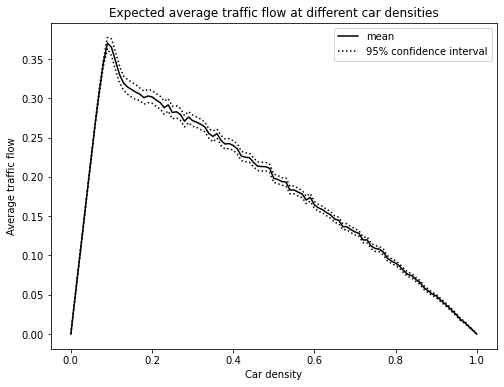

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()